## Let's begin!
Notebook based on brevdev notebook: https://github.com/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb
### 0. Preparing data

Before you check out a GPU, prepare your dataset for loading and training.

To prepare your dataset for loading, all you need are two `.jsonl` files structured something like this:
```
{"input": "What color is the sky?", "output": "The sky is blue."}
{"input": "Where is the best place to get cloud GPUs?", "output": "Brev.dev"}
```

### 1. Instantiate GPU & Load Dataset

In [1]:
# You only need to run this once per machine
!pip install -q -U bitsandbytes
!pip install -q -U transformers
!pip install -q -U peft
!pip install -q -U accelerate

In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='../data_files/json_format1/5w1h_subtask_1_zero_train_train_json_format1.json', encoding = 'utf-8',split='train')
eval_dataset = load_dataset('json', data_files='../data_files/json_format1/5w1h_subtask_1_zero_train_test_json_format1.json', encoding = 'utf-8', split='train')

In [2]:
eval_dataset = eval_dataset

### Accelerator

Set up the Accelerator ([description](https://huggingface.co/docs/accelerate/v0.19.0/en/usage_guides/fsdp)).

In [3]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)


Let's use Weights & Biases to track our training metrics. You'll need to apply an API key when prompted. Feel free to skip this if you'd like, and just comment out the `wandb` parameters in the `Trainer` definition below.

In [4]:
!pip install -q wandb -U

import wandb, os
wandb.login()

wandb_project = "Flares-finetune"
if len(wandb_project) > 0:
    os.environ["WANDB_PROJECT"] = wandb_project

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: jiayunliu2000. Use `wandb login --relogin` to force relogin


### Formatting prompts
Then create a `formatting_func` to structure training examples as prompts.

In [5]:
def formatting_func(example):
    text = f"{example['input']} Output: {example['output']}"
    return text

Here's another common one:

```python
def formatting_func(example):
    text = f"{example['input']} Output: {example['output']}"
    return text
```

### 2. Load Base Model

Let's now load Mistral - mistralai/Mistral-7B-v0.1 - using 4-bit quantization!

In [6]:
!jupyter labextension list

JupyterLab v3.4.6
/opt/conda/share/jupyter/labextensions
        jupyterlab_pygments v0.2.2 enabled OK (python, jupyterlab_pygments)
        jupyter-matplotlib v0.11.2 enabled OK
        @jupyter-widgets/jupyterlab-manager v5.0.3 enabled OK (python, jupyterlab_widgets)



In [7]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

### 3. Tokenization

Set up the tokenizer. Add padding on the left as it [makes training use less memory](https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa).


For `model_max_length`, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def generate_and_tokenize_prompt(prompt):
    return tokenizer(formatting_func(prompt))

Reformat the prompt and tokenize each sample:

In [9]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt)

Let's get a distribution of our dataset lengths, so we can determine the appropriate `max_length` for our input tensors.

1585


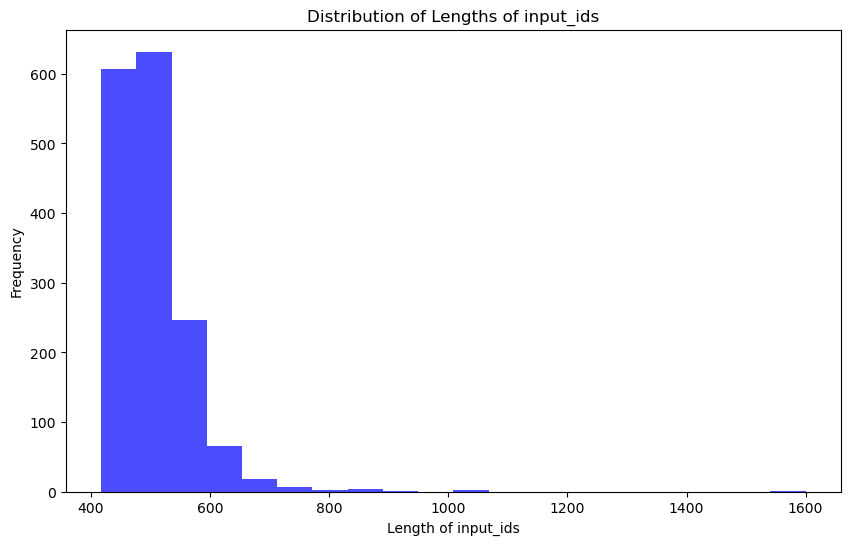

In [10]:
import matplotlib.pyplot as plt

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(len(lengths))

    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(lengths, bins=20, alpha=0.7, color='blue')
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

From here, you can choose where you'd like to set the `max_length` to be. You can truncate and pad training examples to fit them to your chosen size. Be aware that choosing a larger `max_length` has its compute tradeoffs.

Now let's tokenize again with padding and truncation, and set up the tokenize function to make labels and input_ids the same. This is basically what [self-supervised fine-tuning is](https://neptune.ai/blog/self-supervised-learning).

In [11]:
max_length = 700 # This was an appropriate max length for my dataset

def generate_and_tokenize_prompt2(prompt):
    result = tokenizer(
        formatting_func(prompt),
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

In [12]:
tokenized_train_dataset = train_dataset.map(generate_and_tokenize_prompt2)
tokenized_val_dataset = eval_dataset.map(generate_and_tokenize_prompt2)

Check that `input_ids` is padded on the left with the `eos_token` (2) and there is an `eos_token` 2 added to the end, and the prompt starts with a `bos_token` (1).

In [13]:
print(tokenized_train_dataset[2]['input_ids'])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 16063, 261, 7458, 4817, 28706, 481, 2880, 12874, 639, 2245, 28709, 430, 2006, 28717, 296, 1452, 337, 4210, 263, 13693, 385, 3753, 9290, 385, 28725, 24330, 758, 26420, 292, 328, 385, 3459, 3958, 3118, 19931, 15698, 28723, 1136, 603, 28708, 264, 14150, 13693, 28709, 543, 911, 2741, 1632, 10384, 8783, 2388, 1540, 481, 543, 5227, 2895, 955, 2904, 

In [14]:
print(tokenizer.decode(tokenized_train_dataset[2]['input_ids']))

2024-05-14 22:11:26.519293: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como apa

Now all the samples should be the same length, `max_length`.

1585


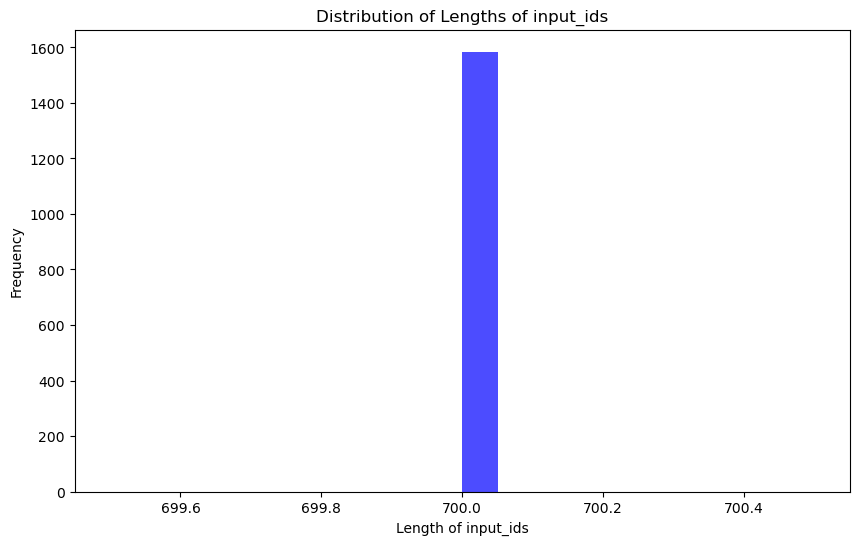

In [15]:
plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

In [16]:
tokenized_train_dataset

Dataset({
    features: ['Id', 'output', 'input', 'tags', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1268
})

In [17]:
print(tokenized_train_dataset['input'][0])

Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como aparecen. Asigna a cada fragmento la etiqueta correspondiente basada en la información que representa. Presenta los resultados en formato JSON. Las categorías de etiquetado son:

WHO: Sujetos o entidades involucradas.
WHAT: Hechos u objetos mencionados.
WHEN: Detalles relacionados con el tiempo.
WHERE: Lugares mencionados.
WHY: Causas o razones.
HOW: Maneras o métodos descritos.

Abajo es un ejemplo:

Input: Dos días, exactamente han pasado dos días desde que Sánchez compareciera en rueda de prensa en la Moncloa afirmando que a España llegarían, entre abril y septiembre, un total de 87 millones de vacunas para darnos cuenta de que las mentiras de Sánchez hacen bueno ese refrán que dice que “la mentira tiene las patas muy cortas”. Output: {'WHO': ['Sánchez', 'a España', 'de Sánchez'], 'WHERE': ['en rueda de prensa en la Moncloa'], 'WHEN': ['entre abril y septiembr

In [18]:
print(tokenized_train_dataset['output'][0])

{'HOW': ['con 45.980 euros'], 'WHAT': ['un estudio sobre el impacto sexista de los piropos'], 'WHEN': None, 'WHERE': ['en un artículo que puedes leer en este enlace'], 'WHO': ['el digital OK Diario', 'el Gobierno de España'], 'WHY': None}


In [19]:
print(tokenized_train_dataset['attention_mask'][0])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [20]:
print(tokenized_train_dataset['input_ids'][0])

[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 16063, 261, 7458, 4817, 28706, 481, 2880, 12874, 639, 2245, 28709, 430, 2006, 28717, 296, 1452, 337, 4210, 263, 13693, 385, 3753, 9290, 385, 28725, 24330, 758, 26420, 292, 328, 385, 3459, 3958, 3118, 19931, 15698, 28723, 1136, 603, 28708, 264, 14150, 13693, 28709, 543, 911, 2741, 1632, 10384, 8783, 2388, 1540, 481, 543, 5227, 2895, 955, 2904, 28708, 28723, 21073, 28708, 1515, 1204, 3482, 481, 1221, 1827, 9292, 28723, 9134, 20577, 12697, 340, 911, 2741, 299, 1452, 1966, 287

In [21]:
print(tokenizer.decode(tokenized_train_dataset['input_ids'][0]))

</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s><s> Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como aparecen. Asigna a cada fragmento la etiqueta correspondiente basada en la información que representa. Presenta los resultados en formato JSON. Las categorías de etiquetado son:



### How does the base model do?

Optionally, you can check how Mistral does on one of your data samples.

In [22]:
eval_prompt = """Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como aparecen. Asigna a cada fragmento la etiqueta correspondiente basada en la información que representa. Presenta los resultados en formato JSON. Las categorías de etiquetado son:

WHO: Sujetos o entidades involucradas.
WHAT: Hechos u objetos mencionados.
WHEN: Detalles relacionados con el tiempo.
WHERE: Lugares mencionados.
WHY: Causas o razones.
HOW: Maneras o métodos descritos.

Abajo es un ejemplo:

Input: Dos días, exactamente han pasado dos días desde que Sánchez compareciera en rueda de prensa en la Moncloa afirmando que a España llegarían, entre abril y septiembre, un total de 87 millones de vacunas para darnos cuenta de que las mentiras de Sánchez hacen bueno ese refrán que dice que “la mentira tiene las patas muy cortas”. Output: {'WHO': ['Sánchez', 'a España', 'de Sánchez'], 'WHERE': ['en rueda de prensa en la Moncloa'], 'WHEN': ['entre abril y septiembre'], 'WHAT': ['un total de 87 millones de vacunas', 'las mentiras', 'ese refrán que dice']}

Ahora, completa la siguiente tarea:

Input: Y es que según informa el digital OK Diario, en un artículo que puedes leer en este enlace, el Gobierno de España ha subvencionado con 45.980 euros un estudio sobre el impacto sexista de los piropos. Output:
"""

In [23]:
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=512, repetition_penalty=1.15)[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como aparecen. Asigna a cada fragmento la etiqueta correspondiente basada en la información que representa. Presenta los resultados en formato JSON. Las categorías de etiquetado son:

WHO: Sujetos o entidades involucradas.
WHAT: Hechos u objetos mencionados.
WHEN: Detalles relacionados con el tiempo.
WHERE: Lugares mencionados.
WHY: Causas o razones.
HOW: Maneras o métodos descritos.

Abajo es un ejemplo:

Input: Dos días, exactamente han pasado dos días desde que Sánchez compareciera en rueda de prensa en la Moncloa afirmando que a España llegarían, entre abril y septiembre, un total de 87 millones de vacunas para darnos cuenta de que las mentiras de Sánchez hacen bueno ese refrán que dice que “la mentira tiene las patas muy cortas”. Output: {'WHO': ['Sánchez', 'a España', 'de Sánchez'], 'WHERE': ['en rueda de prensa en la Moncloa'], 'WHEN': ['entre abril y septiembr

In [24]:
{'HOW': ['con 45.980 euros'], 'WHAT': ['un estudio sobre el impacto sexista de los piropos'], 'WHEN': None, 'WHERE': ['en un artículo que puedes leer en este enlace'], 'WHO': ['el digital OK Diario', 'el Gobierno de España'], 'WHY': None}

{'HOW': ['con 45.980 euros'],
 'WHAT': ['un estudio sobre el impacto sexista de los piropos'],
 'WHEN': None,
 'WHERE': ['en un artículo que puedes leer en este enlace'],
 'WHO': ['el digital OK Diario', 'el Gobierno de España'],
 'WHY': None}

Observe how the model does out of the box.

### 4. Set Up LoRA

Now, to start our fine-tuning, we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [25]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [26]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [27]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

Here we define the LoRA config.

`r` is the rank of the low-rank matrix used in the adapters, which thus controls the number of parameters trained. A higher rank will allow for more expressivity, but there is a compute tradeoff.

`alpha` is the scaling factor for the learned weights. The weight matrix is scaled by `alpha/r`, and thus a higher value for `alpha` assigns more weight to the LoRA activations.

The values used in the QLoRA paper were `r=64` and `lora_alpha=16`, and these are said to generalize well, but we will use `r=32` and `lora_alpha=64` so that we have more emphasis on the new fine-tuned data while also reducing computational complexity.

In [28]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [ ]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

### 5. Run Training!

I didn't have a lot of training samples: only about 200 total train/validation. I used 500 training steps, and I was fine with overfitting in this case. I found that the end product worked well. It took about 20 minutes on the 1x A10G 24GB.

Overfitting is when the validation loss goes up (bad) while the training loss goes down significantly, meaning the model is learning the training set really well, but is unable to generalize to new datapoints. In most cases, this is not desired, but since I am just playing around with a model to generate outputs like my journal entries, I was fine with a moderate amount of overfitting.

With that said, a note on training: you can set the `max_steps` to be high initially, and examine at what step your model's performance starts to degrade. There is where you'll find a sweet spot for how many steps to perform. For example, say you start with 1000 steps, and find that at around 500 steps the model starts overfitting, as described above. Therefore, 500 steps would be your sweet spot, so you would use the `checkpoint-500` model repo in your output dir (`mistral-journal-finetune`) as your final model in step 6 below.

If you're just doing something for fun like I did and are OK with overfitting, you can try different checkpoint versions with different degrees of overfitting.

You can interrupt the process via Kernel -> Interrupt Kernel in the top nav bar once you realize you didn't need to train anymore.

In [ ]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [ ]:
model = accelerator.prepare_model(model)

In [ ]:
import transformers
from datetime import datetime

project = "flare-finetune-train-split-JSON-Template1"
base_model_name = "mistral-7b"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_ratio=0.1,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=1,
        gradient_checkpointing=True,
        num_train_epochs=3,
        learning_rate=2.5e-5, # Want a small lr for finetuning
        bf16=True,
        optim="paged_adamw_8bit",
        logging_steps=100,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=100,                # Save checkpoints every 50 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=100,               # Evaluate and save checkpoints every 50 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}"          # Name of the W&B run (optional)
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.607400,0.285435


/opt/conda/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/opt/conda/lib/python3.10/site-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


KeyboardInterrupt: 

I cleared the output of the cell above because I stopped the training early, and it produced a long, ugly error message.

### 6. Drum Roll... Try the Trained Model!

It's a good idea to kill the current process so that you don't run out of memory loading the base model again on top of the model we just trained. Go to `Kernel > Restart Kernel` or kill the process via the Terminal (`nvidia smi` > `kill [PID]`). 

By default, the PEFT library will only save the QLoRA adapters, so we need to first load the base model from the Huggingface Hub:

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = "mistralai/Mistral-7B-v0.1"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [ ]:
from peft import PeftModel
model_path = "mistral7b-flare-finetune-train-split-JSON-Template1"
ft_model = PeftModel.from_pretrained(base_model, f"{model_path}/checkpoint-1900")

Set stopping criteria to stop the model generating garbage.

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):
    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        last_token = input_ids[0][-1]
        for stop in self.stops:
            if tokenizer.decode(stop) == tokenizer.decode(last_token):
                return True
        return False

In [ ]:
stop_words = ["}", "'}}", "'}\n", "}}\n", "'}\n\n"]
stop_words_ids = [tokenizer(stop_word, return_tensors='pt', add_special_tokens=False)['input_ids'].squeeze() for stop_word in stop_words]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

and run your inference!

Let's try the same `eval_prompt` and thus `model_input` as above, and see if the new finetuned model performs better. I like playing with the repetition penalty (just little tweaks of .01-.05 at a time). THIS IS SO FUN. I'm obsessed wth this AI version of myself.

In [ ]:
eval_prompt = """Tu tarea consiste en analizar el texto proporcionado y extraer fragmentos significativos, transcribiéndolos exactamente como aparecen. Asigna a cada fragmento la etiqueta correspondiente basada en la información que representa. Presenta los resultados en formato JSON. Las categorías de etiquetado son:

WHO: Sujetos o entidades involucradas.
WHAT: Hechos u objetos mencionados.
WHEN: Detalles relacionados con el tiempo.
WHERE: Lugares mencionados.
WHY: Causas o razones.
HOW: Maneras o métodos descritos.

Abajo es un ejemplo:

Input: Dos días, exactamente han pasado dos días desde que Sánchez compareciera en rueda de prensa en la Moncloa afirmando que a España llegarían, entre abril y septiembre, un total de 87 millones de vacunas para darnos cuenta de que las mentiras de Sánchez hacen bueno ese refrán que dice que “la mentira tiene las patas muy cortas”. Output: {'WHO': ['Sánchez', 'a España', 'de Sánchez'], 'WHERE': ['en rueda de prensa en la Moncloa'], 'WHEN': ['entre abril y septiembre'], 'WHAT': ['un total de 87 millones de vacunas', 'las mentiras', 'ese refrán que dice']}

Ahora, completa la siguiente tarea:

Input: Y es que según informa el digital OK Diario, en un artículo que puedes leer en este enlace, el Gobierno de España ha subvencionado con 45.980 euros un estudio sobre el impacto sexista de los piropos. Output:
"""
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    generated_token = ft_model.generate(**model_input, max_new_tokens=512, stopping_criteria=stopping_criteria)[0]

In [ ]:
full_text = eval_tokenizer.decode(generated_token, skip_special_tokens=True)

In [ ]:
print(full_text)

In [ ]:
# Decode only the generated text by slicing the tokens from the length of the input
input_length = model_input['input_ids'].size(1)  # Number of tokens in the input
generated_text = eval_tokenizer.decode(generated_token[input_length:], skip_special_tokens=True)

In [ ]:
print(generated_text)

In [ ]:
{'HOW': ['con 45.980 euros'], 'WHAT': ['un estudio sobre el impacto sexista de los piropos'], 'WHEN': None, 'WHERE': ['en un artículo que puedes leer en este enlace'], 'WHO': ['el digital OK Diario', 'el Gobierno de España'], 'WHY': None}

### Sweet... it worked! The fine-tuned model now prints out journal entries in my style!

How funny to see it write like me as an angsty teenager, and honestly adult. I am obsessed. It knows who my friends are and talks about them, and covers the same topics I usually cover. It's really cool.

That output is quite private but I wanted you to see an example run, so I tweaked the `eval_prompt` so that it explicitly wouldn't say anything too sensitive, haha.

I hope you enjoyed this tutorial on fine-tuning Mistral on your own data. If you have any questions, feel free to reach out to me on [X](https://x.com/harperscarroll) or [Discord](https://discord.gg/RN2a436M73).

🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙 🤙

### 7. FLARE Challenge

In [ ]:
# 1 TASK
print(tokenized_train_dataset.shape)
print(tokenized_val_dataset.shape)

In [ ]:
model_input = f"{tokenized_val_dataset[0]['input']} Output:"
print(model_input)

In [ ]:
ft_model.eval()
with torch.no_grad():
    model_input = eval_tokenizer(model_input, return_tensors="pt").to("cuda")
    generated_token = ft_model.generate(**model_input, max_new_tokens=512, stopping_criteria=stopping_criteria)[0]

In [ ]:
full_text = eval_tokenizer.decode(generated_token, skip_special_tokens=True)
print(full_text)

In [ ]:
# Decode only the generated text by slicing the tokens from the length of the input
input_length = model_input['input_ids'].size(1)  # Number of tokens in the input
generated_text = eval_tokenizer.decode(generated_token[input_length:], skip_special_tokens=True)
print(generated_text)

In [ ]:
tokenized_val_dataset[0]['tags']

Given the generated text transform to FLARE format

In [ ]:
import time

ft_model.eval()
res = []

start_time = time.time()  # Start timing before the loop

for x in tokenized_val_dataset:
    prompt = f"{x['input']} Output: "
    model_input = eval_tokenizer(prompt, return_tensors="pt").to("cuda")
    with torch.no_grad():
        generated_token = ft_model.generate(**model_input, max_new_tokens=512, stopping_criteria=stopping_criteria)[0]
        input_length = model_input['input_ids'].size(1)  # Number of tokens in the input
        generated_text = eval_tokenizer.decode(generated_token[input_length:], skip_special_tokens=True)
        res.append(generated_text)
        
end_time = time.time()  # End timing after the loop

total_time = end_time - start_time
print(f"Total time spent generating text: {total_time:.2f} seconds")

In [ ]:
# Save results
import json

# Save the results to a JSON file
with open(f"{model_path}/results_1900iter.json", "w", encoding="utf-8") as file:
    json.dump(res, file, ensure_ascii=False, indent=4)

# Evaluate results

In [24]:
model_path = "mistral-7b-flare-finetune-train-split-JSON-Template1"

In [52]:
import pandas as pd
import json

# Load results
with open(f"execution_result_test.json", "r", encoding="utf-8") as file:
    org = json.load(file)
    
# Load results
with open(f"extracted_data.json", "r", encoding="utf-8") as file:
    res = json.load(file)

# Load the data
task1_train = pd.read_json('../Flares-dataset/5w1h_subtarea_1_train_train.json', lines=True)
task1_test = pd.read_json('../Flares-dataset/5w1h_subtarea_1_train_test.json', lines=True)

In [53]:
org[0]

{'tokens': ['ĠEsto',
  'Ġse',
  'Ġrefleja',
  'Ġen',
  'Ġla',
  'ĠocupaciÃ³n',
  'Ġde',
  'Ġunidades',
  'Ġde',
  'Ġcuidados',
  'Ġintensivos',
  'Ġ(',
  'U',
  'CI',
  '),',
  'Ġlo',
  'Ġque',
  'Ġse',
  'Ġagrava',
  'Ġcon',
  'Ġla',
  'Ġllegada',
  'Ġde',
  'Ġpacientes',
  'Ġremi',
  'tidos',
  'Ġde',
  'Ġotras',
  'Ġciudades',
  'Ġde',
  'Ġla',
  'ĠregiÃ³n',
  '.'],
 'labels': ['O',
  'O',
  'O',
  'B-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'O',
  'O',
  'O',
  'O',
  'O',
  'B-HOW',
  'I-HOW',
  'I-HOW',
  'B-WHO',
  'I-WHO',
  'I-WHO',
  'I-WHO',
  'B-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'I-WHERE',
  'O'],
 'text': 'Esto se refleja en la ocupación de unidades de cuidados intensivos (UCI), lo que se agrava con la llegada de pacientes remitidos de otras ciudades de la región.',
 'HOW': [' con la llegada'],
 'WHY': [],
 'WHERE': [' en la ocupación de unidades d

In [54]:
res[0:2]

[{'HOW': [' con la llegada'],
  'WHY': [],
  'WHERE': [' en la ocupación de unidades de cuidados intensivos (UCI',
   ' de otras ciudades de la región'],
  'WHO': [' de pacientes remitidos'],
  'WHAT': [],
  'WHEN': []},
 {'HOW': [],
  'WHY': [],
  'WHERE': [],
  'WHO': [' Todos los agentes',
   ' del Comisario Javier Daniel Nogueroles Alonso de la Sierra, un experimentado policía antidisturbios',
   ' los propios efectivos de la UIP'],
  'WHAT': [' «duro» y «expeditivo».'],
  'WHEN': []}]

In [66]:
def convert_to_index_format(data_dict, original_text):
    tags_list = []

    for label, fragments in data_dict.items():
        if fragments is not None:
            for fragment in fragments:
                fragment = fragment.strip()
                start_index = original_text.find(fragment)
                if start_index != -1:
                    end_index = start_index + len(fragment)
                    tags_list.append({
                        'Tag_Start': start_index,
                        'Tag_End': end_index,
                        '5W1H_Label': label,
                        'Tag_Text': fragment
                    })
    
    return tags_list

In [67]:
task1_test['Text'][250]

'El experto ha acompañado el mensaje con una fotografía de uno de los casos observados, en el que se ve una lengua manchada o descolorida.\xa0'

In [68]:
task1_train['Text'][0]

'Y es que según informa el digital OK Diario, en un artículo que puedes leer en este enlace, el Gobierno de España ha subvencionado con 45.980 euros\xa0un estudio sobre el impacto sexista de los piropos.'

In [69]:
org[0]['text']

'Esto se refleja en la ocupación de unidades de cuidados intensivos (UCI), lo que se agrava con la llegada de pacientes remitidos de otras ciudades de la región.'

In [70]:
res[0]

{'HOW': [' con la llegada'],
 'WHY': [],
 'WHERE': [' en la ocupación de unidades de cuidados intensivos (UCI',
  ' de otras ciudades de la región'],
 'WHO': [' de pacientes remitidos'],
 'WHAT': [],
 'WHEN': []}

In [71]:
org[0]['text']

'Esto se refleja en la ocupación de unidades de cuidados intensivos (UCI), lo que se agrava con la llegada de pacientes remitidos de otras ciudades de la región.'

In [72]:
res[0]

{'HOW': [' con la llegada'],
 'WHY': [],
 'WHERE': [' en la ocupación de unidades de cuidados intensivos (UCI',
  ' de otras ciudades de la región'],
 'WHO': [' de pacientes remitidos'],
 'WHAT': [],
 'WHEN': []}

In [73]:
import ast

# Initialize an empty list to store the formatted lists
all_formatted_lists = []

# Assuming 'convert_to_index_format' is a function and 'task1_test' is a dataset with a column 'Text'
for i in range(len(org)):
    try:
        # Convert the current item and get the formatted list
        formatted_list = convert_to_index_format(res[i], org[i]['text'])

        # Append the formatted list to the collection of all formatted lists
        all_formatted_lists.append(formatted_list)
        
    except (SyntaxError, ValueError) as e:
        # If an error occurs, simply skip this item and continue with the next
        all_formatted_lists.append([])

In [29]:
import ast

# Initialize an empty list to store the formatted lists
all_formatted_lists = []

# Assuming 'convert_to_index_format' is a function and 'task1_test' is a dataset with a column 'Text'
for i in range(len(task1_test['Text'])):
    try:
        # Convert the current item and get the formatted list
        formatted_list = convert_to_index_format(ast.literal_eval(res[i]), task1_test['Text'][i])

        # Append the formatted list to the collection of all formatted lists
        all_formatted_lists.append(formatted_list)
        
    except (SyntaxError, ValueError) as e:
        # If an error occurs, simply skip this item and continue with the next
        all_formatted_lists.append([])

In [74]:
# Sorting each sublist by 'Tag_Start' key
sorted_all_formatted_lists = [sorted(sub_list, key=lambda x: x['Tag_Start']) for sub_list in all_formatted_lists]

In [76]:
import pprint

pp = pprint.PrettyPrinter(indent=1, width=80, depth=None, compact=False)
for i in range(0,2):
    print(f"####Generated tags")
    pp.pprint(sorted_all_formatted_lists[i])
    print(f"####Ground Truh tags")
    pp.pprint(tokenized_val_dataset[i]['tags'])

####Generated tags
[{'5W1H_Label': 'WHERE',
  'Tag_End': 71,
  'Tag_Start': 16,
  'Tag_Text': 'en la ocupación de unidades de cuidados intensivos (UCI'},
 {'5W1H_Label': 'HOW',
  'Tag_End': 105,
  'Tag_Start': 91,
  'Tag_Text': 'con la llegada'},
 {'5W1H_Label': 'WHO',
  'Tag_End': 128,
  'Tag_Start': 106,
  'Tag_Text': 'de pacientes remitidos'},
 {'5W1H_Label': 'WHERE',
  'Tag_End': 159,
  'Tag_Start': 129,
  'Tag_Text': 'de otras ciudades de la región'}]
####Ground Truh tags


NameError: name 'tokenized_val_dataset' is not defined

In [33]:
# Extract both 'tags' and 'Id' from each entry and store them in a list of dictionaries
ground_truth = [{'Id': entry['Id'], 'Tags': f"{entry['tags']}"} for entry in tokenized_val_dataset]

In [135]:
ground_truth[135]

{'Id': 1476,
 'Tags': "[{'5W1H_Label': 'WHO', 'Reliability_Label': 'confiable', 'Tag_End': 143, 'Tag_Start': 138, 'Tag_Text': 'a\\xa0CNN'}]"}

In [136]:
"""
Virginia Evaluation code
# Generated using ChatGPT

def evaluate_spans(predicted_spans, gold_spans):
    # Initialize counters for different types of matches
    total_correct_matches = 0
    total_incorrect_matches = 0
    total_partial_matches = 0
    total_missing_matches = 0
    total_spurious_matches = 0

    # Iterate over each pair of predicted and gold documents
    for predicted_spans, gold_spans in zip(predicted_spans, gold_spans):
        correct_matches = 0
        incorrect_matches = 0
        partial_matches = 0
        missing_matches = len(gold_spans)  # Initialize with total gold spans for this document
        spurious_matches = 0

        # Iterate through each gold span in the current document
        for gold_span in gold_spans:
            found_match = False  # Flag to track if a match is found for the current gold span

            # Iterate through each predicted span in the current document
            for predicted_span in predicted_spans:
                # Check if start and end indices and labels match exactly
                if (gold_span['Tag_Start'] == predicted_span['Tag_Start'] and
                    gold_span['Tag_End'] == predicted_span['Tag_End'] and
                    gold_span['5W1H_Label'] == predicted_span['5W1H_Label']):
                    correct_matches += 1
                    found_match = True
                    break

                # Check if start and end indices match but labels don't
                elif (gold_span['Tag_Start'] == predicted_span['Tag_Start'] and
                      gold_span['Tag_End'] == predicted_span['Tag_End']):
                    incorrect_matches += 1
                    found_match = True
                    break

                # Check for partial matches
                elif (gold_span['Tag_Start'] <= predicted_span['Tag_End'] and
                      gold_span['Tag_End'] >= predicted_span['Tag_Start']):
                    partial_matches += 1
                    found_match = True
                    break

            # If no match is found, decrement the missing match counter
            if found_match:
                missing_matches -= 1

        # Calculate spurious matches for the current document
        spurious_matches = len(predicted_spans) - (correct_matches + incorrect_matches + partial_matches)

        # Accumulate document-level results into total results
        total_correct_matches += correct_matches
        total_incorrect_matches += incorrect_matches
        total_partial_matches += partial_matches
        total_missing_matches += missing_matches
        total_spurious_matches += spurious_matches

    return total_correct_matches, total_incorrect_matches, total_partial_matches, total_missing_matches, total_spurious_matches


# Example usage:
gold_spans = [{"Tag_Start":5,"Tag_End":23,"5W1H_Label":"WHO","Reliability_Label":"semiconfiable","Tag_Text":"los investigadores"},{"Tag_Start":39,"Tag_End":101,"5W1H_Label":"WHAT","Reliability_Label":"confiable","Tag_Text":"evidencia de que la aspirina aumentara el riesgo de hemorragia"},{"Tag_Start":102,"Tag_End":146,"5W1H_Label":"WHO","Reliability_Label":"confiable","Tag_Text":"en los pacientes hospitalizados con COVID-19"}]
predicted_spans = [{"Tag_Start":9,"Tag_End":23,"5W1H_Label":"WHO","Reliability_Label":"semiconfiable","Tag_Text":"investigadores"},{"Tag_Start":39,"Tag_End":101,"5W1H_Label":"WHERE","Reliability_Label":"confiable","Tag_Text":"evidencia de que la aspirina aumentara el riesgo de hemorragia"},{"Tag_Start":24,"Tag_End":38,"5W1H_Label":"HOW","Reliability_Label":"confiable","Tag_Text":"en los pacientes hospitalizados con COVID-19"}]

# Call the function with gold and predicted spans
correct, incorrect, partial, missing, spurious = evaluate_spans(sorted_all_formatted_lists, ground_truth)

# Print the evaluation metrics
print("Correct Matches:", correct)
print("Incorrect Matches:", incorrect)
print("Partial Matches:", partial)
print("Missing Matches:", missing)
print("Spurious Matches:", spurious)

recall = (correct + (0.5 * partial)) / (correct + incorrect + partial + missing)

precision = (correct + (0.5 * partial)) / (correct + incorrect + partial + spurious)

f1 = 2 * (precision * recall) / (precision + recall)

print(f"Recall: {recall}, Precision: {precision}, F1: {f1}")
"""

'\nVirginia Evaluation code\n# Generated using ChatGPT\n\ndef evaluate_spans(predicted_spans, gold_spans):\n    # Initialize counters for different types of matches\n    total_correct_matches = 0\n    total_incorrect_matches = 0\n    total_partial_matches = 0\n    total_missing_matches = 0\n    total_spurious_matches = 0\n\n    # Iterate over each pair of predicted and gold documents\n    for predicted_spans, gold_spans in zip(predicted_spans, gold_spans):\n        correct_matches = 0\n        incorrect_matches = 0\n        partial_matches = 0\n        missing_matches = len(gold_spans)  # Initialize with total gold spans for this document\n        spurious_matches = 0\n\n        # Iterate through each gold span in the current document\n        for gold_span in gold_spans:\n            found_match = False  # Flag to track if a match is found for the current gold span\n\n            # Iterate through each predicted span in the current document\n            for predicted_span in predicted

In [137]:

# Prepare the text content
#metrics_content = f"""
#Correct Matches: {correct}
#Incorrect Matches: {incorrect}
#Partial Matches: {partial}
#Missing Matches: {missing}
#Spurious Matches: {spurious}
#Recall: {recall:.4f}
#Precision: {precision:.4f}
#F1 Score: {f1:.4f}
#"""

# Save to a text file
#with open(f"{model_path}/evaluation_metrics.txt", "w") as file:
#    file.write(metrics_content)

#print("Metrics have been saved to 'evaluation_metrics.txt'.")

SyntaxError: invalid decimal literal (3873642842.py, line 9)

In [139]:
# Create a DataFrame using the IDs and the corresponding formatted tag lists
tags_df = pd.DataFrame({
    'Id': task1_test['Id'],
    'Tags': [str(tags) for tags in sorted_all_formatted_lists]  # Convert each list to a string and enclose it in single quotes
})

print(tags_df.columns)

Index(['Id', 'Tags'], dtype='object')


In [140]:
# Now save this DataFrame to a CSV file
tags_df.to_csv(f"{model_path}/tags_data_1900iter.csv", index=False)

In [141]:
ground_truth[135]

{'Id': 1476,
 'Tags': "[{'5W1H_Label': 'WHO', 'Reliability_Label': 'confiable', 'Tag_End': 143, 'Tag_Start': 138, 'Tag_Text': 'a\\xa0CNN'}]"}

In [142]:
ground_truth = pd.DataFrame(ground_truth)

In [90]:
# Now save this DataFrame to a CSV file
ground_truth.to_csv(f"{model_path}/ground_truth.csv", index=False)

In [91]:
ground_truth['Tags'][135]

"[{'5W1H_Label': 'WHO', 'Reliability_Label': 'confiable', 'Tag_End': 143, 'Tag_Start': 138, 'Tag_Text': 'a\\xa0CNN'}]"

# TEST FLARE CHALLENGE

In [143]:
!python "../evaluate_subtask_1.py" --pathDataGold /mistral7b-flare-finetune-train-split-JSON-Template1/ground_truth.csv --pathDataInfered /mistral7b-flare-finetune-train-split-JSON-Template1/tags_data_1900iter.csv

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


       Id                                               Tags
0    1382  [{'Tag_Start': 40, 'Tag_End': 88, '5W1H_Label'...
1     553  [{'Tag_Start': 14, 'Tag_End': 20, '5W1H_Label'...
2     567  [{'Tag_Start': 0, 'Tag_End': 52, '5W1H_Label':...
3     483  [{'Tag_Start': 15, 'Tag_End': 23, '5W1H_Label'...
4     938  [{'Tag_Start': 6, 'Tag_End': 33, '5W1H_Label':...
..    ...                                                ...
312  1447  [{'Tag_Start': 5, 'Tag_End': 18, '5W1H_Label':...
313   583  [{'Tag_Start': 197, 'Tag_End': 221, '5W1H_Labe...
314   766                                                 []
315  1097  [{'Tag_Start': 38, 'Tag_End': 62, '5W1H_Label'...
316   789  [{'Tag_Start': 20, 'Tag_End': 27, '5W1H_Label'...

[317 rows x 2 columns]
[{'Precision': 0.638142747505756, 'Recall': 0.5859760394644116, 'F1': 0.6109478324761205, 'Accuracy': 0.4917208752217623}]
